In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Preparation

In [2]:
n_samples = 2000
outliers_fraction = 0.02
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# read inliers
data = pd.read_csv("../data/MAGIC/magic04.data", header=None)
X_inliers = resample(data[[2, 4]].values, replace=False, n_samples=n_inliers, random_state=42)
X_inliers = StandardScaler().fit_transform(X_inliers)

# generate outliers
X_outliers = np.random.RandomState(42).uniform(low=-6, high=6, size=(n_outliers, 2))

# concatenate
X = np.concatenate((X_inliers, X_outliers), axis=0)
y = np.array([0]*len(X_inliers) + [1]*len(X_outliers))

In [4]:
def plot_Xy(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Inliers')
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Outliers')
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.xlabel(r'$X_1$', size=14)
    plt.ylabel(r'$X_2$', size=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.legend(loc='best', fontsize=14)
    plt.show()

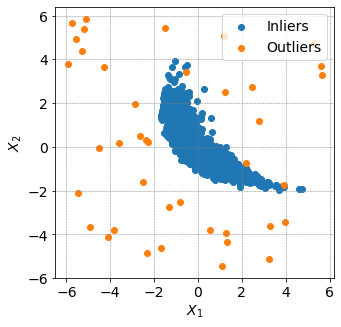

In [5]:
plot_Xy(X, y)

# Train / Test Split

In [6]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

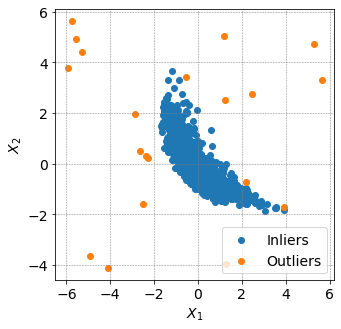

In [7]:
plot_Xy(X_test, y_test)

# Generative Adversarial Network (GAN)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's define a Generator of our GAN.

In [9]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, x_noise):
        x = x_noise
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

Now, let's also define a Discriminator of the GAN.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

In this example we implement `WGAN` wiht Wassestein distance as a loss function. Let's train our GAN.

In [11]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    
    def fit(self, X):
        
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch,) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # generate a batch of fake observations
                fake_batch = self.generate(len(real_batch))
    
                ### Discriminator
                # measure discriminator's ability to classify real from fake samples
                loss_disc = -torch.mean(self.discriminator(real_batch)) + torch.mean(self.discriminator(fake_batch))

                # optimization step
                self.opt_disc.zero_grad()
                loss_disc.backward(retain_graph=True)
                self.opt_disc.step()

                # Clip weights of discriminator
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                ### Generator
                if i % self.n_critic == 0:
                    
                    # measures generator's ability to fool the discriminator
                    loss_gen = torch.mean(self.discriminator(real_batch)) - torch.mean(self.discriminator(fake_batch))
                    
                    # optimization step
                    self.opt_gen.zero_grad()
                    loss_gen.backward()
                    self.opt_gen.step()
                    
            # caiculate and store loss after an epoch
            X_fake = self.generate(len(X_real))
            loss_epoch = torch.mean(self.discriminator(X_real)) - torch.mean(self.discriminator(X_fake))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)
        
        
    def generate(self, N):
        noise = Variable(torch.tensor(np.random.normal(0, 1, (N, self.latent_dim)), dtype=torch.float, device=DEVICE))
        # noise = Variable(torch.tensor(2*np.random.rand(N, self.latent_dim)-1, dtype=torch.float, device=DEVICE))
        X_gen = self.generator(noise)
        return X_gen
    
    def discriminate(self, X):
        intput = torch.tensor(X, dtype=torch.float, device=DEVICE)
        output = self.discriminator(intput).detach().numpy()
        return output

Finally, we will train our WGAN on normal data.

In [12]:
%%time
latent_dim = 2
generator     = Generator(latent_dim, 2)
discriminator = Discriminator(2)

fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train[y_train==0])

CPU times: user 1min 18s, sys: 1.38 s, total: 1min 19s
Wall time: 1min 20s


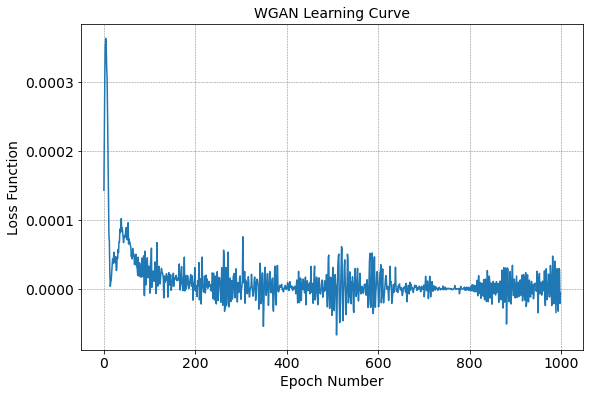

In [13]:
# WGAN learning curve
plt.figure(figsize=(9, 6))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Consider examples of generated objects.

In [14]:
# sample objects from known distribution in latent space Z
Z_gen = Variable(torch.tensor(np.random.normal(0, 1, (len(X_train), latent_dim)), dtype=torch.float, device=DEVICE))
# using object in latent sapce, generate fake objects using the Generator
X_gen = fitter.generator(Z_gen).cpu().detach().numpy()
Z_gen = Z_gen.cpu().detach().numpy()

In [15]:
def plot_generated_objs(Z_gen, X_gen, X):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(Z_gen[:, 0], Z_gen[:, 1], label="Fake", color='C0')
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], label="Real", color='C1')
    plt.scatter(X_gen[:, 0], X_gen[:, 1], label="Fake", color='C0')
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

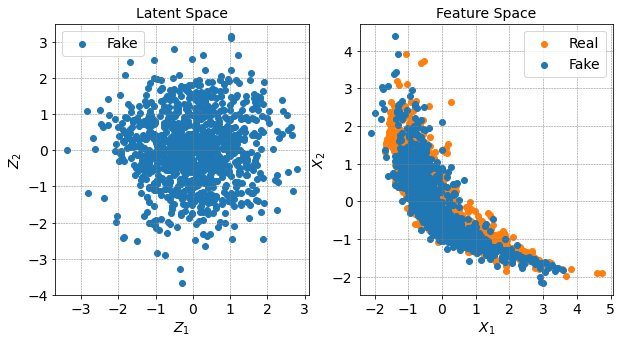

In [16]:
plot_generated_objs(Z_gen, X_gen, X_train[y_train==0])

Now, let's consider what the Generator does more detailed.

In [17]:
r_min = 3
r_max = 5

In [18]:
# sample objects in latent space Z uniformly
Z_u = np.random.uniform(low=-10, high=10, size=(5000, 2))

# select all objects within r_min and r_max radius
r = np.sqrt(Z_u[:, 0]**2 + Z_u[:, 1]**2)
Z_u = Z_u[(r >= r_min)*(r < r_max)]

# generate object in feature space X using the Generator
X_u = fitter.generator(torch.tensor(Z_u, dtype=torch.float, device=DEVICE)).detach().cpu()

In [19]:
def plot_fake_fake(Z1, Z2, X1, X2):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(Z1[:, 0], Z1[:, 1], label="Fake1", color='C1', alpha=0.5)
    plt.scatter(Z2[:, 0], Z2[:, 1], label="Fake2", color='C0', alpha=0.5)
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 2)
    plt.scatter(X1[:, 0], X1[:, 1], label="Fake1", color='C1', alpha=0.5)
    plt.scatter(X2[:, 0], X2[:, 1], label="Fake2", color='C0', alpha=0.5)
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

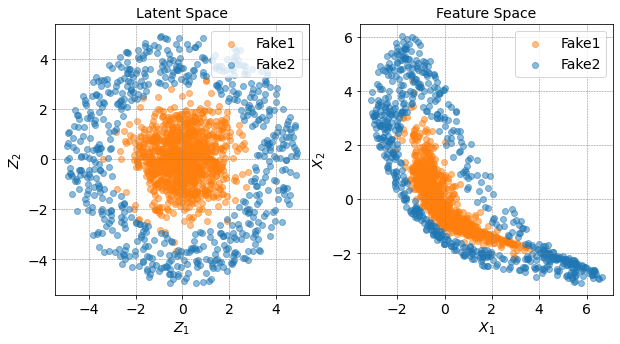

In [20]:
plot_fake_fake(Z_gen, Z_u, X_gen, X_u)

# Anomalies Detection: Approach 1

In [21]:
X_train_ano = np.concatenate((X_train, X_u), axis=0)
y_train_ano = np.concatenate((y_train, np.ones(len(X_u))))

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

# define and fit a classifier
clf1 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6)
clf1.fit(X_train_ano, y_train_ano)

# get predictions for test
y_test_pred_ano = clf1.predict_proba(X_test)[:, 1]

# calculate quality metrics
auc = roc_auc_score(y_test, y_test_pred_ano)
print("ROC AUC:", auc)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_ano >= 0.5).ravel()
print("TP:", tp, "FP:", fp)
print("FN:", fn, "TN:", tn)

ROC AUC: 0.9989285714285714
TP: 20 FP: 13
FN: 0 TN: 967


In [23]:
# define and fit a classifier
clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6)
clf2.fit(X_train, y_train)

# get predictions for test
y_test_pred = clf2.predict_proba(X_test)[:, 1]

# calculate quality metrics
auc = roc_auc_score(y_test, y_test_pred)
print("ROC AUC:", auc)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred >= 0.5).ravel()
print("TP:", tp, "FP:", fp)
print("FN:", fn, "TN:", tn)

ROC AUC: 0.7518622448979592
TP: 11 FP: 0
FN: 9 TN: 980


In [24]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=1000)
iso.fit(X_test)
y_test_pred = -iso.score_samples(X_test)

# calculate quality metrics
auc = roc_auc_score(y_test, y_test_pred)
print("ROC AUC:", auc)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred >= 0.5).ravel()
print("TP:", tp, "FP:", fp)
print("FN:", fn, "TN:", tn)

ROC AUC: 0.9951020408163266
TP: 20 FP: 94
FN: 0 TN: 886


# Bidirectional GAN (BiGAN)

In [25]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, 1)

    def forward(self, x, z):
        xz = torch.cat((x,z), dim=1)
        x = self.fc1(xz)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

In [26]:
class BiFitter(object):
    
    def __init__(self, generator, discriminator, encoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(list(self.generator.parameters()) + list(self.encoder.parameters()), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        self.encoder.to(DEVICE)
    
    
    def fit(self, X):
        
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        self.encoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch,) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # generate a batch of fake objects
                z_batch = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), self.latent_dim)), dtype=torch.float, device=DEVICE))
                fake_batch = self.generator(z_batch)
                
                # encode real objects back into latent space
                z_enc_batch = self.encoder(real_batch)
                
                ### Discriminator
                real_output = self.discriminator(real_batch, z_enc_batch)
                fake_output = self.discriminator(fake_batch, z_batch)
                
                ### Loss
                loss_disc = - torch.mean(real_output) + torch.mean(fake_output)
                #loss_disc = torch.mean(torch.log(real_output)) + torch.mean(1 - torch.log(fake_output))
                
                self.opt_disc.zero_grad()
                loss_disc.backward(retain_graph=True)
                self.opt_disc.step()
                
                # Clip weights of discriminator
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                
                ### Train Generator
                
                if i % self.n_critic == 0:
                    
                    real_output = self.discriminator(real_batch, z_enc_batch)
                    fake_output = self.discriminator(fake_batch, z_batch)
                    
                    loss_gen = - torch.mean(fake_output) + torch.mean(real_output)
                    #loss_gen = - torch.mean(torch.log(real_output)) - torch.mean(1 - torch.log(fake_output))

                    self.opt_gen.zero_grad()
                    loss_gen.backward()
                    self.opt_gen.step()
                    
            # caiculate and store loss after an epoch
            Z = Variable(torch.tensor(np.random.normal(0, 1, (len(X_real), self.latent_dim)), dtype=torch.float, device=DEVICE))
            X_fake = self.generator(Z)
            Z_enc = self.encoder(X_real)
            real_output = self.discriminator(X_real, Z_enc)
            fake_output = self.discriminator(X_fake, Z)
            loss_epoch = torch.mean(real_output) - torch.mean(fake_output)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)
        self.encoder.train(False)
        
        
    def generate(self, N):
        noise = Variable(torch.tensor(np.random.normal(0, 1, (N, self.latent_dim)), dtype=torch.float, device=DEVICE))
        # noise = Variable(torch.tensor(2*np.random.rand(N, self.latent_dim)-1, dtype=torch.float, device=DEVICE))
        X_gen = self.generator(noise)
        return X_gen
    
    def discriminate(self, X):
        intput = torch.tensor(X, dtype=torch.float, device=DEVICE)
        output = self.discriminator(intput).detach().numpy()
        return output

In [27]:
%%time
latent_dim = 2
generator     = Generator(latent_dim, 2)
encoder       = Encoder(2, latent_dim)
discriminator = Discriminator(2+latent_dim)

fitter = BiFitter(generator, discriminator, encoder, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train[y_train==0])

CPU times: user 1min 39s, sys: 1.02 s, total: 1min 40s
Wall time: 1min 40s


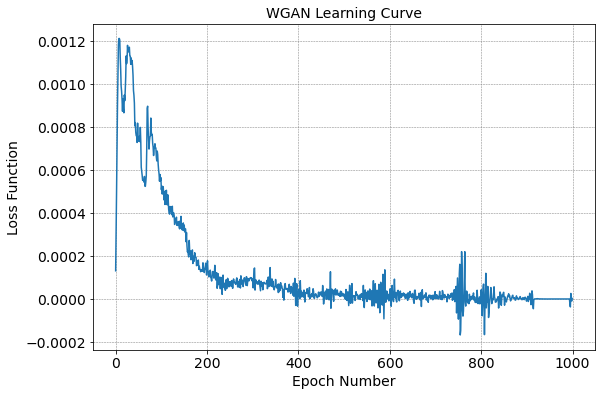

In [28]:
# WGAN learning curve
plt.figure(figsize=(9, 6))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

In [29]:
# sample objects from known distribution in latent space Z
Z_gen = Variable(torch.tensor(np.random.normal(0, 1, (len(X_train), latent_dim)), dtype=torch.float, device=DEVICE))
# using object in latent sapce, generate fake objects using the Generator
X_gen = fitter.generator(Z_gen).cpu().detach().numpy()
Z_gen = Z_gen.cpu().detach()

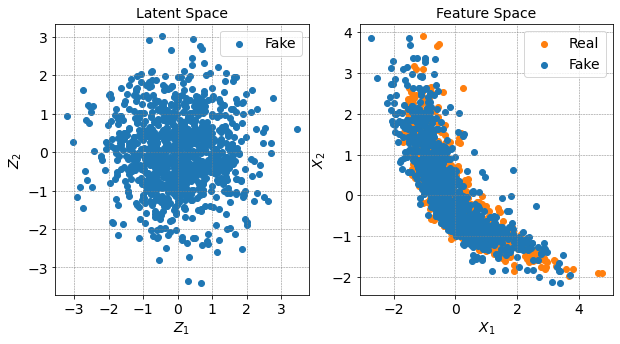

In [30]:
plot_generated_objs(Z_gen, X_gen, X_train[y_train==0])

In [31]:
# using object in latent sapce, generate fake objects using the Generator
Z_enc = fitter.encoder(torch.tensor(X_train[y_train==0], dtype=torch.float, device=DEVICE)).cpu().detach()

In [32]:
def plot_encoded_objs(X, Z_enc):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 2)
    plt.scatter(Z_enc[:, 0], Z_enc[:, 1], label="Encoded objects", color='C0')
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], label="Objects", color='C0')
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

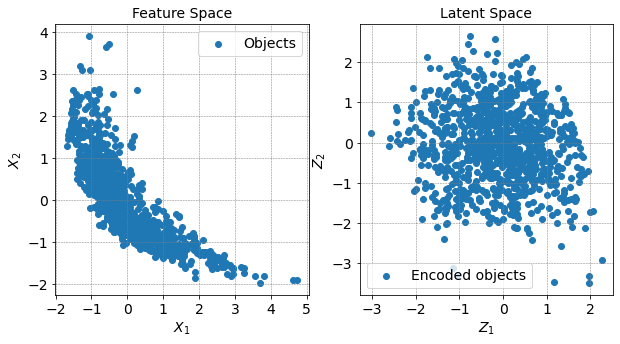

In [33]:
plot_encoded_objs(X_train[y_train==0], Z_enc)

In [34]:
r_min = 5
r_max = 10

In [35]:
# sample objects in latent space Z uniformly
X_u = np.random.uniform(low=-10, high=10, size=(5000, 2))

# select all objects within r_min and r_max radius
r = np.sqrt(X_u[:, 0]**2 + X_u[:, 1]**2)
X_u = X_u[(r >= r_min)*(r < r_max)]

# generate object in feature space X using the Generator
Z_enc_u = fitter.encoder(torch.tensor(X_u, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()

In [36]:
# using object in latent sapce, generate fake objects using the Generator
Z_enc_gen = fitter.encoder(torch.tensor(X_gen, dtype=torch.float, device=DEVICE)).cpu().detach().numpy()

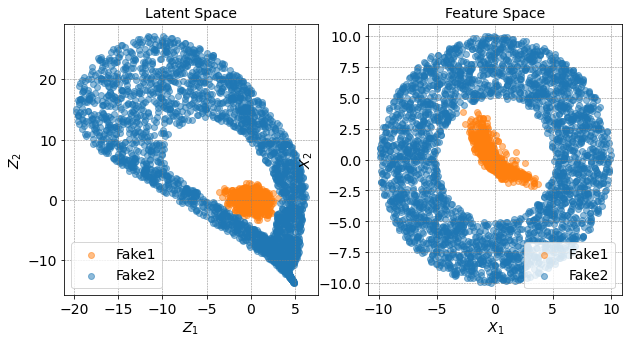

In [37]:
plot_fake_fake(Z_enc_gen, Z_enc_u, X_gen, X_u)

In [38]:
X_enc_gen_u = fitter.generator(torch.tensor(Z_enc_u, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()
X_enc_gen_gen = fitter.generator(torch.tensor(Z_enc_gen, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()

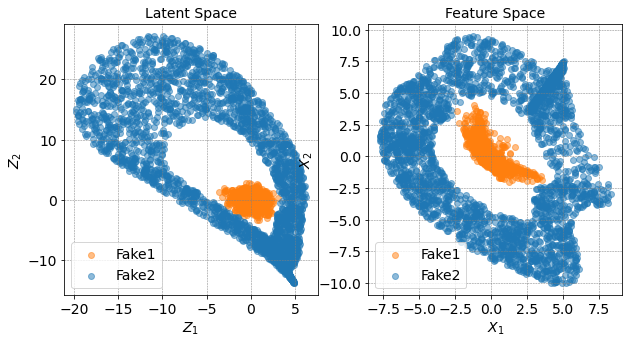

In [39]:
plot_fake_fake(Z_enc_gen, Z_enc_u, X_enc_gen_gen, X_enc_gen_u)

# Anomaly Detection: Approach 2

In [40]:
Z_enc = fitter.encoder(torch.tensor(X_test, dtype=torch.float, device=DEVICE))
X_gen = fitter.generator(Z_enc)

D_real = fitter.discriminator(torch.tensor(X_test, dtype=torch.float, device=DEVICE), Z_enc)
D_gen  = fitter.discriminator(X_gen, Z_enc)

In [41]:
Z_enc = Z_enc.detach().cpu().numpy()
X_gen = X_gen.detach().cpu().numpy()

D_real = D_real.detach().cpu().numpy()
D_gen = D_gen.detach().cpu().numpy()

In [42]:
Lg = np.abs(X_test - X_gen).sum(axis=1)
Ld = np.abs(D_real - D_gen).sum(axis=1)

Rz = np.sqrt((Z_enc**2).sum(axis=1))

(0.0, 10.0)

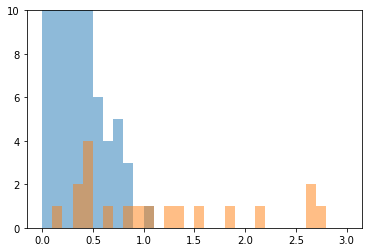

In [43]:
bins = np.linspace(0, 3, 31)
plt.hist(Lg[y_test==0], bins=bins, density=False, alpha=0.5)
plt.hist(Lg[y_test==1], bins=bins, density=False, alpha=0.5)
plt.ylim(0, 10)

(0.0, 10.0)

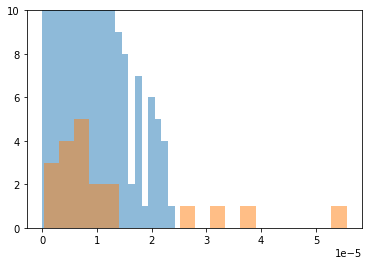

In [44]:
bins = 20#np.linspace(0, 0.0003, 31)
plt.hist(Ld[y_test==0], bins=bins, density=False, alpha=0.5)
plt.hist(Ld[y_test==1], bins=bins, density=False, alpha=0.5)
plt.ylim(0, 10)

(0.0, 10.0)

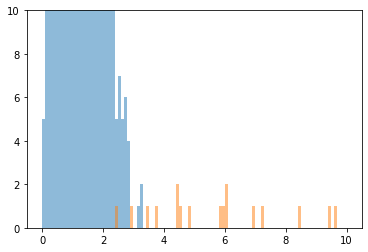

In [45]:
bins = np.linspace(0, 10, 101)
plt.hist(Rz[y_test==0], bins=bins, density=False, alpha=0.5)
plt.hist(Rz[y_test==1], bins=bins, density=False, alpha=0.5)
plt.ylim(0, 10)

In [46]:
auc = roc_auc_score(y_test, Lg)
print("ROC AUC:", auc)

auc = roc_auc_score(y_test, Ld)
print("ROC AUC:", auc)

auc = roc_auc_score(y_test, Rz)
print("ROC AUC:", auc)

ROC AUC: 0.9618877551020408
ROC AUC: 0.7983163265306124
ROC AUC: 0.9985714285714286
